## Fiducial tracking

In this example we'll discuss how to do fiducial tracking for drift correction.

### Configuration

In real experiments you'd have fiducials that you were also imaging, either in the same color channel as the data, or in a different color channel. You would then create two localization files, one that at least mostly contains the locations of the fiducials, and another file that contains all the localizations.

In [1]:
import os
os.chdir("/home/hbabcock/Data/storm_analysis/jy_testing/")
print(os.getcwd())

import numpy
numpy.random.seed(1) # Set seed so that the example is repeatable.

/home/hbabcock/Data/storm_analysis/jy_testing


Generate sample data for this example.

In [2]:
import storm_analysis.jupyter_examples.fiducial_tracking as fiducial_tracking

# Make a simulated movie.
fiducial_tracking.makeSampleData()

# Make a 3D-DAOSTORM analysis XML file.
fiducial_tracking.daoSTORMXML()


/home/hbabcock/pyenv/jupyter/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Creating random localizations.
Frame 0 16 emitters
Frame 1 25 emitters
Frame 2 27 emitters
Frame 3 28 emitters
Frame 4 28 emitters
Frame 5 28 emitters
Frame 6 28 emitters
Frame 7 28 emitters
Frame 8 27 emitters
Frame 9 27 emitters
Frame 10 26 emitters
Frame 11 25 emitters
Frame 12 27 emitters
Frame 13 27 emitters
Frame 14 28 emitters
Frame 15 28 emitters
Frame 16 27 emitters
Frame 17 26 emitters
Frame 18 27 emitters
Frame 19 26 emitters
Frame 20 26 emitters
Frame 21 26 emitters
Frame 22 26 emitters
Frame 23 27 emitters
Frame 24 27 emitters
Frame 25 26 emitters
Frame 26 27 emitters
Frame 27 26 emitters
Frame 28 25 emitters
Frame 29 27 emitters
Frame 30 28 emitters
Frame 31 26 emitters
Frame 32 27 emitters
Frame 33 27 emitters
Frame 34 25 emitters
Frame 35 27 emitters
Frame 36 27 emitters
Frame 37 26 emitters
Frame 38 26 emitters
Frame 39 28 emitters
Frame 40 27 emitters
Frame 41 28 emitters
Frame 42 28 emitters
Frame 43 28 emitters
Frame 44 28 emitters
Frame 45 26 emitters
Frame 46 26 e

### Analyze fiducials with 3D-DAOSTORM

In [3]:
import storm_analysis.daostorm_3d.mufit_analysis as mfit

if os.path.exists("fiducials.hdf5"):
    os.remove("fiducials.hdf5")
    
mfit.analyze("fiducials.tif", "fiducials.hdf5", "daostorm.xml")


Peak finding
 Removing values < 1.0 in frame 0
Frame: 0 15 15
 Removing values < 1.0 in frame 1
Frame: 1 24 39
 Removing values < 1.0 in frame 2
Frame: 2 27 66
 Removing values < 1.0 in frame 3
Frame: 3 28 94
 Removing values < 1.0 in frame 4
Frame: 4 28 122
 Removing values < 1.0 in frame 5
Frame: 5 28 150
 Removing values < 1.0 in frame 6
Frame: 6 28 178
 Removing values < 1.0 in frame 7
Frame: 7 28 206
 Removing values < 1.0 in frame 8
Frame: 8 27 233
 Removing values < 1.0 in frame 9
Frame: 9 27 260
 Removing values < 1.0 in frame 10
Frame: 10 26 286
 Removing values < 1.0 in frame 11
Frame: 11 25 311
 Removing values < 1.0 in frame 12
Frame: 12 27 338
 Removing values < 1.0 in frame 13
Frame: 13 27 365
 Removing values < 1.0 in frame 14
Frame: 14 28 393
 Removing values < 1.0 in frame 15
Frame: 15 28 421
 Removing values < 1.0 in frame 16
Frame: 16 27 448
Frame: 17 26 474
 Removing values < 1.0 in frame 18
Frame: 18 26 500
 Removing values < 1.0 in frame 19
Frame: 19 26 526
 Remo

### Track fiducials

In [4]:
import storm_analysis.sa_utilities.fiducials as fiducials

# max_gap - Number of after which a fiducial will be considered to be lost.
# radius - Matching radius in pixels.
# reference_frame - Localizations from this frame will all be treated as fiducials.
#
fiducials.trackFiducials("fiducials.hdf5", max_gap = 4, radius = 1, reference_frame = 4)

 processing frame 0, 28 fiducials


### Plot results

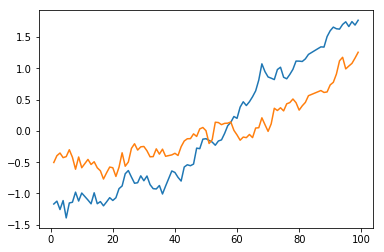

In [5]:
import matplotlib.pyplot as pyplot

with fiducials.SAH5Fiducials("fiducials.hdf5") as h5:
    fdcl = h5.getFiducial(1, fields = ["x", "y"])
    
    x = fdcl["x"] - numpy.mean(fdcl["x"])
    y = fdcl["y"] - numpy.mean(fdcl["y"])
    
    pyplot.plot(fdcl["frame"], x)
    pyplot.plot(fdcl["frame"], y)
    pyplot.show()
    

### Measure the drift

We'll do this by averaging together all of the fiducials.

In [6]:
import scipy
import scipy.interpolate

x_drift = None
y_drift = None

with fiducials.SAH5Fiducials("fiducials.hdf5") as h5:
    ml = h5.getMovieLength()
    x = numpy.arange(ml)
    x_drift = numpy.zeros(ml)
    y_drift = numpy.zeros(ml)
    
    n_fiducials = 0
    for fdcl in h5.fiducialsIterator(fields = ["x", "y"]):

        # Verify this fiducial was present in most of the frames.
        if (fdcl["frame"].size < int(0.9 * ml)):
            continue
        
        # Use linear interpolation to fill in missing values.
        xpos_int = scipy.interpolate.interp1d(fdcl["frame"], 
                                              fdcl["x"], 
                                              kind = 'linear', 
                                              fill_value = 'extrapolate')
        
        ypos_int = scipy.interpolate.interp1d(fdcl["frame"], 
                                              fdcl["y"], 
                                              kind = 'linear', 
                                              fill_value = 'extrapolate')

        x_drift += xpos_int(x)
        y_drift += ypos_int(x)
        n_fiducials += 1
        
    print(n_fiducials, "fiducials were usedout of", h5.getNFiducials(), "were used.")
    x_drift = x_drift/(float(n_fiducials))
    y_drift = y_drift/(float(n_fiducials))        

25 fiducials were used out of 28 were used.


Since this a pretty common operation, the SAH5Fiducials class also provides this as a method.

In [7]:
with fiducials.SAH5Fiducials("fiducials.hdf5") as h5:
    [ave_fdcl, n_averaged] = h5.averageFiducials(fields = ["x", "y"], min_frac_occupancy = 0.9)
    print(n_fiducials, "fiducials were used out of", h5.getNFiducials(), "were used.")

print()
print("x difference {0:.3f}".format(numpy.max(numpy.abs(ave_fdcl["x"] - x_drift))))
print("y difference {0:.3f}".format(numpy.max(numpy.abs(ave_fdcl["y"] - y_drift))))
x_drift -= x_drift[0]


25 fiducials were used out of 28 were used.

x difference 0.000
y difference 0.000


### Compare with ground truth

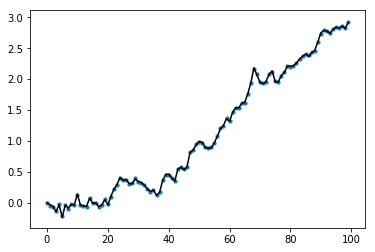

Mean x error: 0.006243 pixels


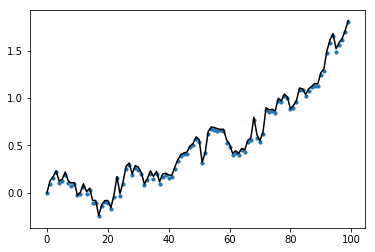

Mean y error: 0.020435 pixels


In [8]:
gt_drift = numpy.loadtxt("drift.txt")

gt_x = gt_drift[:,0] - gt_drift[0,0]
x_drift -= x_drift[0]
pyplot.plot(gt_x, color = "black")
pyplot.scatter(numpy.arange(x_drift.size), x_drift, s = 10)
pyplot.show()
print("Mean x error: {0:3f} pixels".format(numpy.mean(numpy.abs(gt_x - x_drift))))

gt_y = gt_drift[:,1] - gt_drift[0,1]
y_drift -= y_drift[0]
pyplot.plot(gt_y, color = "black")
pyplot.scatter(numpy.arange(y_drift.size), y_drift, s = 10)
pyplot.show()
print("Mean y error: {0:3f} pixels".format(numpy.mean(numpy.abs(gt_y - y_drift))))


### Apply drift correction and verify

Here we're just applying it to the fiducial data file. Normally you'd probably apply it to the localizations data file.

In [9]:
import storm_analysis.sa_library.sa_h5py as saH5Py

with saH5Py.SAH5Py("fiducials.hdf5") as h5:
    for i in range(x_drift.size):
        h5.setDriftCorrection(i, dx = -x_drift[i], dy = -y_drift[i])

In [10]:
with fiducials.SAH5Fiducials("fiducials.hdf5") as h5:
    fdcl = h5.getFiducial(1, fields = ["x"])
    print("Uncorrected: {0:.3f} pixels".format(numpy.std(fdcl["x"])))
    
    fdcl = h5.getFiducial(1, drift_corrected = True, fields = ["x"])
    print("Corrected: {0:.3f} pixels".format(numpy.std(fdcl["x"])))

Uncorrected: 0.997 pixels
Corrected: 0.034 pixels
